#Qunatum teleportation

Quantum teleportation is a process that allows the state of a quantum particle (like a qubit) to be transferred from one location to another without physically moving the particle itself. Instead of sending the particle, the information about its quantum state is transmitted, so the receiver can recreate the original state exactly.

The process works by first creating a pair of entangled particles and sharing them between the sender (often called Alice) and the receiver (Bob). Alice then performs special measurements on her qubit and on the qubit whose state she wishes to teleport. She sends the results (which are just two regular bits of information) to Bob using an ordinary communication channel.

### 1. Setup

First install qiskit and matplotlib.

In [36]:
!pip install qiskit qiskit-aer matplotlib

In [37]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector

### 2. Quantum teleportation method

This method requires three qubits and two classical bits.
- Qubit 0 (q0): The qubit to be teleported (Alice).
- Qubit 1 (q1): One of the entangled qubit (Alice).
- Qubit 2 (q2): The other entangled qubit (Bob).

We also need two classical bits to record the results when alice measures her two qubits.

In [38]:
#we define quantum and classical registers and create the teleportation circuit
qubits = QuantumRegister(3, name="qubits")
alice_Z_result = ClassicalRegister(1, name="alice_Z_result")
alice_X_result = ClassicalRegister(1, name="alice_X_result")

teleportation_circuit = QuantumCircuit(qubits, alice_Z_result, alice_X_result)

### 3. Create of a state to be teleported

Create a random quantum state to teleport. Create a state with a random rotation around the Y and Z axes. This will be our message "psi"

Initial state:
Statevector([ 0.28240006+0.58210803j, -0.33281515+0.68602808j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2, 2))


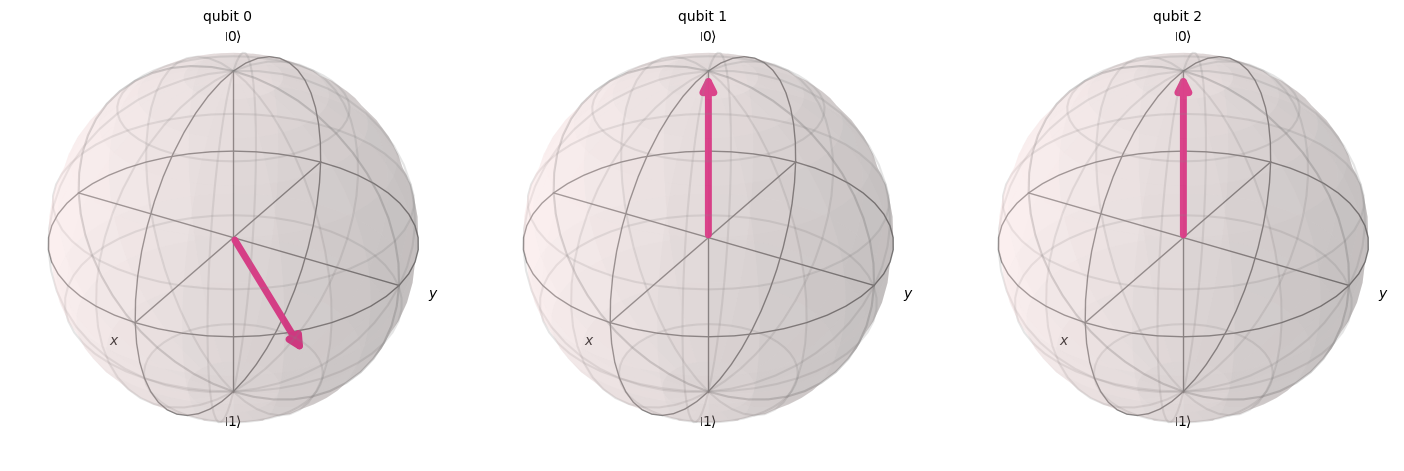

In [39]:
def create_initial_state(circuit, qubit):
    circuit.ry(np.random.rand() * 2 * np.pi, qubit)
    circuit.rz(np.random.rand() * 2 * np.pi, qubit)

#apply the initial state to the first qubit
create_initial_state(teleportation_circuit, 0)
teleportation_circuit.barrier()

#shown using bloch sphere
initial_state = Statevector.from_instruction(teleportation_circuit)
print("Initial state:")
print(initial_state)
plot_bloch_multivector(initial_state)

### 4. Create an entangled pair

First take Alice's second qubit (q1) and pass it through hadamard gate, which puts it into a superposition. Next we use a CNOT gate: Alice's q1 acts like the control qubit, and Bob's (q2) is the target qubit. q1 and q2 are now entangled.

In [40]:
def create_entangled_pair(circuit, q1, q2):
    circuit.h(q1)
    circuit.cx(q1, q2)

create_entangled_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "qubits"), index=0>, <Qubit register=(3, "qubits"), index=1>, <Qubit register=(3, "qubits"), index=2>), clbits=())

### 5. Alice's operations

Alice applies a CNOT gate on her two qubits (q0 and q1) and then a Hadamard gate on q0. After this, she measures the state of both qubits.

In [41]:
def alice_gates(circuit, q0, q1):
    circuit.cx(q0, q1)
    circuit.h(q0)

#gates application
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.barrier()

#qubit measurement
teleportation_circuit.measure(0, alice_Z_result)
teleportation_circuit.measure(1, alice_X_result)

### 6. Bob's operations

Alice sends her two classical bits to Bob. Based on the values of these bits, Bob applies a specific gates to his qubit (q2) to reconstruct the original state "psi"

- If alice_Z_result is 1, he applies an X gate
- If alice_X_result is 1, he applies a Z gate

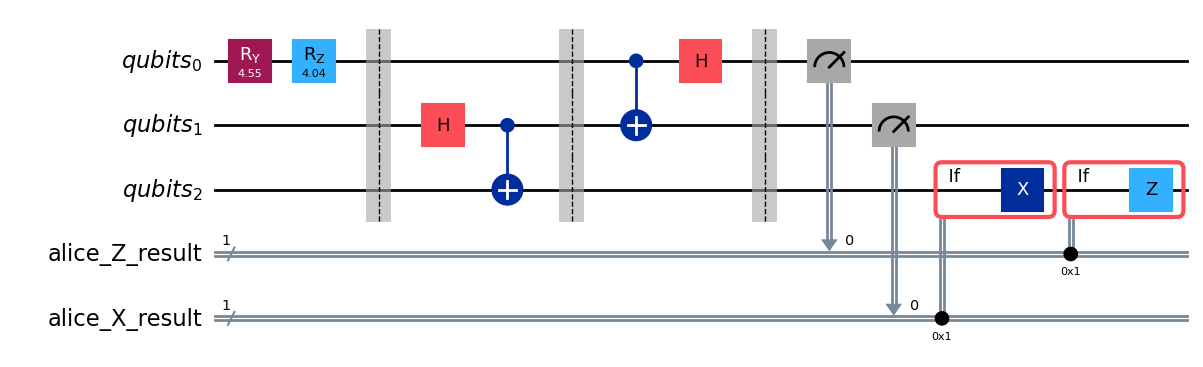

In [42]:
#gate application
with teleportation_circuit.if_test((alice_X_result, 1)):
    teleportation_circuit.x(2)
with teleportation_circuit.if_test((alice_Z_result, 1)):
    teleportation_circuit.z(2)

#circuit diagram
teleportation_circuit.draw('mpl')

### 7. simulation

Test the circuit to see if the teleportation was successful using simulation. We will use AerSimulator. We will get state vector of final state of Bob's qubit and compare it with initial state.

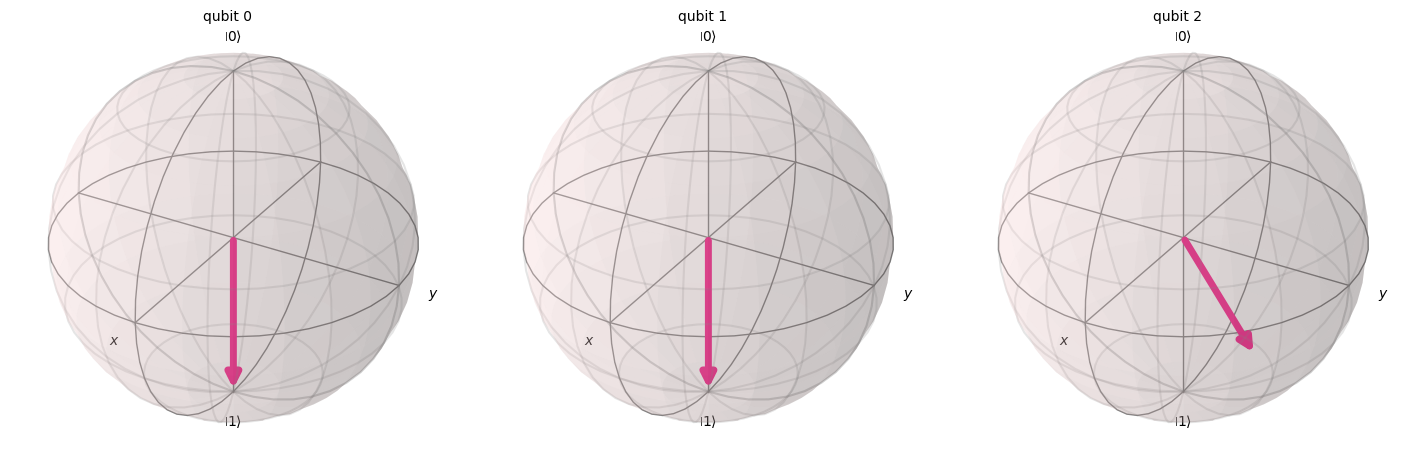

In [43]:
simulator = AerSimulator()

#circuit for final state vector
bob_qubit_circuit = teleportation_circuit.copy()
bob_qubit_circuit.save_statevector()

#transpile for simulator
transpile_bob_qubit_circuit = transpile(bob_qubit_circuit, simulator)

#simulation run
result = simulator.run(transpile_bob_qubit_circuit).result()
final_statevector = result.get_statevector(transpile_bob_qubit_circuit)
plot_bloch_multivector(final_statevector)

### 8. Results

The bloch sphere above shows state of all three qubits after the teleportation protocol. If the teleportation was successful, the state of Bob's qubit (q2) should be identical to the initial state of Alice's qubit (q0).

We can calculate the fidelity between initial state of q0 and the final state of q2. A fidelity value of 1 means states are identical.

In [44]:
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix

#density matriz of final state
final_density_matrix = DensityMatrix(final_statevector)

#trace out first two qubits (Alice's) to get the state of Bob's qubit
bob_final_density_matrix = partial_trace(final_density_matrix, [0, 1])
bob_final_state = bob_final_density_matrix.to_statevector()

#get initial state of q0
initial_q0_density_matrix = partial_trace(initial_state, [1, 2])
initial_q0_state = initial_q0_density_matrix.to_statevector()

#fidelity check
fidelity = np.abs(np.dot(initial_q0_state.data.conj(), bob_final_state.data))**2

print(f"Initial state of q0: {initial_q0_state.data}")
print(f"Final state of q2: {bob_final_state.data}")
print(f"fidelity: {fidelity}")

if np.isclose(fidelity, 1.0):
    print("Teleportation was successful!")
else:
    print("Teleportation failed.")

Initial state of q0: [0.40046814-0.50815825j 0.7624962 +0.j        ]
Final state of q2: [0.40046814-0.50815825j 0.7624962 +0.j        ]
fidelity: 0.9999999999999998
Teleportation was successful!


### 9. Histogram of Measurements

We can run the experiment multiple times and plot histogram of measurement outcomes of Alice's qubits. This shows the probabilities of measuring 00, 01, 10, or 11. Each outcome should appoximately appear equally.

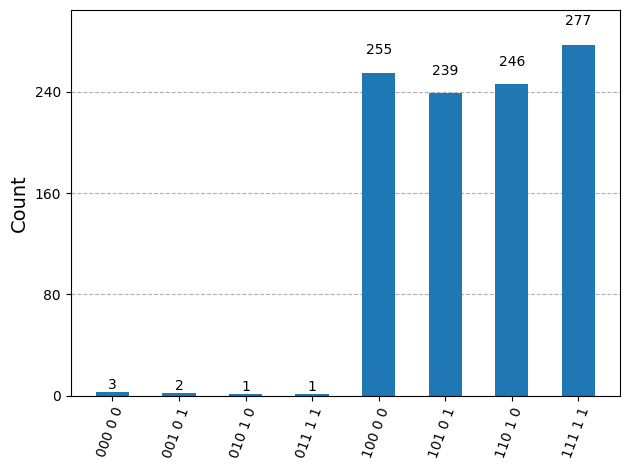

In [26]:
#new circuit for measurement
measurement_circuit = teleportation_circuit.copy()
measurement_circuit.measure_all(inplace=True)

t_measurement_circuit = transpile(measurement_circuit, simulator)
result_meas = simulator.run(t_measurement_circuit, shots=1024).result()
counts = result_meas.get_counts(t_measurement_circuit)

plot_histogram(counts)

### Conclusion

This code demonstrated the quantum teleportation protocol using qiskit. Firstly we created a quantum circuit that teleports the state of one qubit to another. The fidelity value of 1 confirms that the final state of Bob's qubit is the same as the initial state of Alice's qubit